# Imports

In [62]:
import numpy as np
import sympy as sp
from matplotlib import pyplot as plt
from IPython.display import display
from scipy.special import erfc
from rich.console import Console
from rich.panel import Panel
console=Console()
sp.init_printing()

# Impulse response

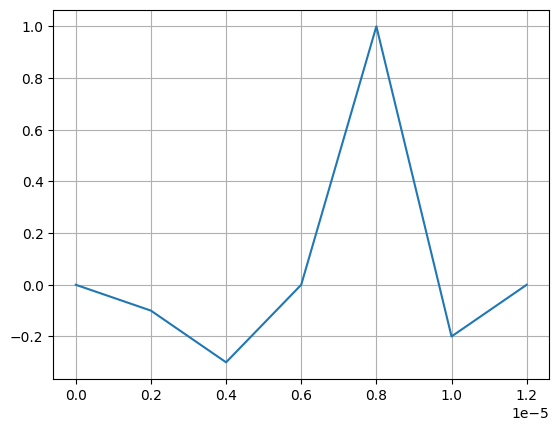

In [36]:
h = [0, -0.1, -0.3, 0, 1, -0.2, 0]
t = np.arange(0, 14, 2) * 1e-6
plt.plot(t, h)
plt.grid()
plt.show()

# RB

In [37]:
def RB_without(h, t):
    last_zero = len(h) - 1
    max_idx = np.argmax(h)
    j = 0
    pj = -1
    nodes = []
    mnidx = 0
    for i in range(len(h)):
        if h[i] == 0:
            if j != pj:
                nodes.append(i)
                pj = j
            nodes[-1] = i
        elif i == max_idx:
            nodes.append(i)
            mnidx = len(nodes) - 1
            j += 1
        else:
            j += 1
    return 1 / np.abs(t[np.argmax(np.diff(nodes))] - t[max_idx])

In [38]:
print(f"RB without ISI: {RB_without(h,t)} bps")
print(f"RB without ISI: {RB_without(h,t)/1000} Kbps")

RB without ISI: 125000.0 bps
RB without ISI: 125.0 Kbps


# LTE equalization

## Helper functions

In [39]:
def gen_y(h):
    max_idx = np.argmax(h)
    y = np.zeros(len(h))
    y[max_idx] = 1
    return y

In [40]:
def gen_coef(LTE, n):
    return sp.symbols(
        ["C_{" + str(i) + "\\," + str(n) + "}" for i in range(1 - LTE[0], LTE[1] + 1)]
    )

In [41]:
def get_last_zero(harr):
    for n,h in enumerate(harr[::-1]):
        if h != 0:
            return len(harr) - n
    return 0

In [42]:
def gen_eq(harr,coef,yarr):
    max_idx = np.argmax(harr)
    res=np.convolve(coef, harr)
    res[get_last_zero(harr)]-=1
    return res

## Design parameters

In [43]:
Rb=5e5
LTE=[3,2]

## Generate system of equations

In [44]:
coef = gen_coef(LTE, 0)
yarr = gen_y(h)
eqs = gen_eq(h,coef,yarr)

In [45]:
for eq in eqs:
    display(eq)

# Solve system of equations using zero forcing

In [46]:
def zero_forcing(eqs, coef, harr):
    max_idx = np.argmax(harr)
    cvals = [
        sp.solve(eqs[i : i + len(coef)])
        for i in range(max_idx - 1, len(eqs) - len(coef))
    ]
    cvals=[cval for cval in cvals if len(cval)==len(coef)]
    errors=[np.abs(
        sum(eq.subs(cval) for eq in eqs if eq!=0)) for cval in cvals
    ]
    print("error for each set of coeficients:", errors)
    print("result for each set of equations:")
    for cval in cvals:
        display(cval)
    print("selected set of equations:")
    for eq in eqs[max_idx - 1 +np.argmin(errors):max_idx - 1 +np.argmin(errors)+len(coef)]:
        display(eq)
    return cvals[np.argmin(errors)]

In [70]:
coef_0 = zero_forcing(eqs, coef, h)
coef_0

error for each set of coeficients: [1.55549480590487, 0.298420615128845, 13.0000000000000]
result for each set of equations:


selected set of equations:


## Compute the peak distortion

In [54]:
def peak_dist(eqs, coef_0, h):
    max_idx = np.argmax(h)
    DP = np.sum([np.abs(h) for n, h in enumerate(h) if n != max_idx]) / h[max_idx]
    DP_p = np.sum(
        [
            np.abs(eq.subs(coef_0))
            for n, eq in enumerate(eqs)
            if n != (max_idx + get_last_zero(h))
        ]
    ) / np.abs(eqs[max_idx + get_last_zero(h)].subs(coef_0)+1)
    return DP, DP_p

In [56]:
DP,DP_p=peak_dist(eqs, coef_0, h)
print(f"DP: {DP}")
print(f"DP': {DP_p}")

DP: 0.6000000000000001
DP': 0.298420615128845


## SINR Improvement

In [58]:
max_idx = np.argmax(h)
d_min = h[max_idx] - DP
d_min_p = np.abs(eqs[max_idx + get_last_zero(h)].subs(coef_0) + 1) - DP_p
print(f"d_min: {d_min}")
print(f"d_min': {d_min_p}")
print(f"d_min-d_min': {d_min-d_min_p}")

d_min: 0.3999999999999999
d_min': 0.701579384871155
d_min-d_min': -0.301579384871156


In [61]:
delta_SINR=(d_min_p/d_min)/sp.sqrt(sum([np.abs(coef_0[c])**2 for n,c in enumerate(coef)]))
print("\u0394SINR lineal:",delta_SINR.evalf())
print("\u0394SINR en dB:",sp.sympify(20*sp.log(delta_SINR,10)).evalf())


ΔSINR lineal: 1.56700930861765
ΔSINR en dB: 3.90143152693748


# BER

In [76]:
sigma_n_2 = 0.5  # W
x = d_min / (np.sqrt(2) * np.sqrt(sigma_n_2))
P_b = 0.5 * erfc(x)
if np.abs(np.round(x, 1) - x) > 0.015:
    print("revisar con la tabla")
console.print(
    Panel(
        f"x: {x}\nP_b: {P_b}",
        title="Without eq",
        style="bold yellow" if np.abs(np.round(x, 1) - x) > 0.015 else "bold green",
    )
)

sigma_eq = sp.sqrt(
    sigma_n_2 * sum([np.abs(coef_0[c]) ** 2 for n, c in enumerate(coef)])
)
x_p = float(d_min_p / (sigma_eq * np.sqrt(2)))
P_b_p = 0.5 * erfc(x_p)

console.print(
    Panel(
        f"x': {x_p}\nP_b': {P_b_p}",
        title="With eq",
        style="bold yellow" if np.abs(np.round(x_p, 1) - x_p) > 0.015 else "bold green",
    )
)
if np.abs(np.round(x_p, 1) - x_p) > 0.01:
    print("revisar con la tabla")

╭────────────────────────────────────────────────── Without eq ───────────────────────────────────────────────────╮
│ x: 0.3999999999999998                                                                                           │
│ P_b: 0.28580382247666586                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── With eq ────────────────────────────────────────────────────╮
│ x': 0.626803723447059                                                                                           │
│ P_b': 0.18769176430576523                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

revisar con la tabla


# Learning rate

In [78]:
def get_sorted_coef(coef,n):
  if type(coef)==list:
    return coef
  return [coef[sp.Symbol("C_{"+str(i)+","+str(n)+"}")] for i in range(1-LTE[0],LTE[1]+1)]

In [82]:
def compute_y(z_arr,z_0,coef,n,LTE):
  scoef=get_sorted_coef(coef,n)
  return sum([z*c for z,c in zip(z_arr[z_0-LTE[1]:z_0+LTE[0]],scoef[::-1])])

In [80]:
def compute_delta(coef,n,delta,z_arr,z_0,diff,LTE):
  scoef=get_sorted_coef(coef,n)
  y=compute_y(z_arr,z_0,coef,n,LTE)
  print("y["+str(n)+"] =",y,"e["+str(n)+"]", y-np.sign(y),)
  print("C["+str(n)+"] =", scoef[LTE[0]-1])
  eq=(delta)*np.abs(y-np.sign(y))*z_arr[z_0]-diff*scoef[LTE[0]-1]
  return np.abs(sp.solve(eq)[0])

In [81]:
def compute_next_coef(coef,n,delta,z_arr,z_0,LTE):
  scoef=get_sorted_coef(coef,n)
  y=compute_y(z_arr,z_0,coef,n,LTE)
  print("y["+str(n)+"] =",y,"e["+str(n)+"]", y-np.sign(y),)
  nextcoef=[c-delta*(y-np.sign(y))*z
            for c,z in zip(scoef[::-1],
                              z_arr[z_0-LTE[1]:z_0+LTE[0]])]
  return nextcoef

In [83]:
z=[.95,-1.05,0.8,-0.85,-1.15,1.25,-1.1]
z_0=3
delta=sp.Symbol("Delta")
nextcoef=compute_next_coef(coef_0,0,delta,z,z_0,LTE)[::-1]
for eq in nextcoef:
  display(eq)


y[0] = -0.497921862011638 e[0] 0.502078137988362


In [86]:
diff=0.07
delta_res=compute_delta(coef_0,0,delta,z,z_0,diff,LTE)
print("Δ =", delta_res)

y[0] = -0.497921862011638 e[0] 0.502078137988362
C[0] = 1.03906899418121
Δ = 0.170432411375146


In [87]:
nextcoef1=compute_next_coef(coef_0,0,delta_res,z,z_0,LTE)[::-1]
for i,eq in enumerate(nextcoef1):
  print("C",i-LTE[0]+1)
  display(eq)

y[0] = -0.497921862011638 e[0] 0.502078137988362
C -2


C -1


C 0


C 1


C 2


In [88]:
nextcoef2=compute_next_coef(nextcoef1,1,delta_res,z,z_0+1,LTE)[::-1]
for i,eq in enumerate(nextcoef2):
  print("C",i-LTE[0]+1)
  display(eq)

y[1] = -1.25073346046648 e[1] -0.250733460466481
C -2


C -1


C 0


C 1


C 2


# DFE

In [89]:
def compute_DFE(h_arr):
  idx=len(h_arr)-get_last_zero(h_arr)
  print(idx)
  return[1/h_arr[idx]]+[-h/h_arr[idx] for h in h_arr[idx+1:]][:len(nextcoef)-1]

In [90]:
compute_DFE(h)

1
